# Import libraries

In [ ]:
import os
import re
import json
import random
import string
import time
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score, classification_report
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF
from sklearn.preprocessing import LabelEncoder
from sklearn_crfsuite import metrics
import sklearn_crfsuite

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

# Pre-processing

In [2]:
# Build text samples and annotations
def build_dataset(train_csv, docs_dir, sample_size=1000, seed=42, test_size=0.2):
    df = pd.read_csv(train_csv)
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

    text_samples, annotations = [], []
    for _, row in df.iterrows():
        doc_id, dataset_label = row["Id"], row["dataset_label"]
        doc_path = os.path.join(docs_dir, f"{doc_id}.json")
        if not os.path.exists(doc_path):
            continue

        with open(doc_path, "r") as f:
            doc_json = json.load(f)

        for section in doc_json:
            text = section.get("text", "")
            if dataset_label.lower() in text.lower():
                annots = []
                start = 0
                while True:
                    idx = text.lower().find(dataset_label.lower(), start)
                    if idx == -1:
                        break
                    annots.append({"start": idx, "end": idx + len(dataset_label), "label": "DATASET"})
                    start = idx + len(dataset_label)
                text_samples.append(text)
                annotations.append(annots)

    # Random sample
    sample_indices = random.sample(range(len(text_samples)), min(sample_size, len(text_samples)))
    text_samples = [text_samples[i] for i in sample_indices]
    annotations = [annotations[i] for i in sample_indices]

    print(f"Randomly sampled {len(text_samples)} annotated texts.")

    return text_samples, annotations

# Develop NER labeler for pre-training data
class NERLabeler:
    def __init__(self):
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
        # Common dataset indicators and patterns
        self.dataset_indicators = {
            'survey_terms': ['survey', 'census', 'longitudinal', 'panel', 'cohort'],
            'data_terms': ['data', 'dataset', 'database', 'repository', 'archive'],
            'source_terms': ['bureau', 'agency', 'administration', 'institute', 'center'],
            'acronyms': ['CPS', 'ACS', 'NLSY', 'PSID', 'GSS', 'NHANES', 'SIPP']
        }
        
        # BIO tagging scheme: B-DATASET, I-DATASET, O
        self.label_encoder = LabelEncoder()
        
    def preprocess_text(self, text):
        """
        Preprocess text for better feature extraction.
        """
        # Remove extra whitespace and normalize
        text = re.sub(r'\s+', ' ', text.strip())
        return text
    
    def extract_word_features(self, sent, i):
        """
        Extract comprehensive features for word at position i in sentence.
        Features are designed specifically for dataset citation recognition.
        """
        word = sent[i]
        features = {
            # Basic word features
            'bias': 1.0,
            'word.lower()': word.lower(),
            'word[-3:]': word[-3:],  # suffix
            'word[-2:]': word[-2:],  # suffix
            'word.isupper()': word.isupper(),
            'word.istitle()': word.istitle(),
            'word.isdigit()': word.isdigit(),
            'word.isalpha()': word.isalpha(),
            'word.isalnum()': word.isalnum(),
            'len(word)': len(word),
            
            # Dataset-specific features
            'contains.digit': any(c.isdigit() for c in word),
            'contains.hyphen': '-' in word,
            'contains.underscore': '_' in word,
            'contains.parentheses': '(' in word or ')' in word,
            'all.caps': word.isupper() and len(word) > 1,
            
            # Acronym detection
            'is.acronym': (word.isupper() and len(word) >= 2 and len(word) <= 6),
            'known.dataset.acronym': word.upper() in self.dataset_indicators['acronyms'],
            
            # Dataset indicator terms
            'is.survey.term': word.lower() in self.dataset_indicators['survey_terms'],
            'is.data.term': word.lower() in self.dataset_indicators['data_terms'],
            'is.source.term': word.lower() in self.dataset_indicators['source_terms'],
            
            # Punctuation features
            'has.punctuation': any(c in string.punctuation for c in word),
            'ends.with.period': word.endswith('.'),
            'ends.with.comma': word.endswith(','),
            
            # Morphological features
            'stemmed': self.stemmer.stem(word.lower()),
            'lemmatized': self.lemmatizer.lemmatize(word.lower()),
        }
        
        # Context features (previous and next words)
        if i > 0:
            word1 = sent[i-1]
            features.update({
                '-1:word.lower()': word1.lower(),
                '-1:word.istitle()': word1.istitle(),
                '-1:word.isupper()': word1.isupper(),
                '-1:is.survey.term': word1.lower() in self.dataset_indicators['survey_terms'],
                '-1:is.data.term': word1.lower() in self.dataset_indicators['data_terms'],
                '-1:is.source.term': word1.lower() in self.dataset_indicators['source_terms'],
            })
        else:
            features['BOS'] = True  # Beginning of sentence
            
        if i < len(sent)-1:
            word1 = sent[i+1]
            features.update({
                '+1:word.lower()': word1.lower(),
                '+1:word.istitle()': word1.istitle(),
                '+1:word.isupper()': word1.isupper(),
                '+1:is.survey.term': word1.lower() in self.dataset_indicators['survey_terms'],
                '+1:is.data.term': word1.lower() in self.dataset_indicators['data_terms'],
                '+1:is.source.term': word1.lower() in self.dataset_indicators['source_terms'],
            })
        else:
            features['EOS'] = True  # End of sentence
            
        # Bigram features
        if i > 0:
            features['-1,0:words'] = f"{sent[i-1].lower()}_{word.lower()}"
        if i < len(sent)-1:
            features['0,+1:words'] = f"{word.lower()}_{sent[i+1].lower()}"
            
        # Window features (±2 words)
        if i > 1:
            features['-2:word.lower()'] = sent[i-2].lower()
        if i < len(sent)-2:
            features['+2:word.lower()'] = sent[i+2].lower()
            
        return features
    
    def sent2features(self, sent):
        """Convert sentence to feature vectors."""
        return [self.extract_word_features(sent, i) for i in range(len(sent))]
    
    def sent2labels(self, sent_labels):
        """Extract labels from sentence."""
        return sent_labels
    
    def sent2tokens(self, sent):
        """Extract tokens from sentence."""
        return sent
    
    def create_training_data_from_text(self, text_samples, annotations):
        """
        Create training data from text samples and their annotations.
        
        Args:
            text_samples: List of text strings
            annotations: List of annotations in format [{'start': int, 'end': int, 'label': str}]
        
        Returns:
            X_train, y_train: Features and labels for training
        """
        X, y = [], []
        
        for text, annots in zip(text_samples, annotations):
            # Tokenize text
            tokens = word_tokenize(text)
            labels = ['O'] * len(tokens)
            
            # Convert character-based annotations to token-based labels
            char_to_token = self._create_char_to_token_mapping(text, tokens)
            
            for annot in annots:
                start_char, end_char = annot['start'], annot['end']
                entity_type = annot.get('label', 'DATASET')
                
                # Find corresponding tokens
                start_token = char_to_token.get(start_char)
                end_token = char_to_token.get(end_char - 1)  # end_char is exclusive
                
                if start_token is not None and end_token is not None:
                    # Apply BIO tagging
                    labels[start_token] = f'B-{entity_type}'
                    for i in range(start_token + 1, end_token + 1):
                        if i < len(labels):
                            labels[i] = f'I-{entity_type}'
            
            X.append(tokens)
            y.append(labels)
        
        return X, y
    
    def _create_char_to_token_mapping(self, text, tokens):
        """Create mapping from character positions to token indices."""
        char_to_token = {}
        char_idx = 0
        
        for token_idx, token in enumerate(tokens):
            # Find token in text starting from current position
            while char_idx < len(text) and text[char_idx].isspace():
                char_idx += 1
            
            # Map all characters in this token
            token_start = char_idx
            for i in range(len(token)):
                if char_idx < len(text):
                    char_to_token[char_idx] = token_idx
                    char_idx += 1
        
        return char_to_token
    
    def prepare_training_data(self, X_tokens, y_labels):
        """
        Prepare feature vectors and labels for CRF training.
        """
        X_features = [self.sent2features(sent) for sent in X_tokens]
        y_formatted = [self.sent2labels(labels) for labels in y_labels]
        
        return X_features, y_formatted

# Generate data for training and testing

In [3]:
# Paths
train_csv = "/Users/davepipon/Desktop/DS397 Data/coleridgeinitiative-show-us-the-data/train.csv"
docs_dir = "/Users/davepipon/Desktop/DS397 Data/coleridgeinitiative-show-us-the-data/train/"

# Generate data for training and testing
text_samples, annotations = build_dataset(train_csv, docs_dir, sample_size=100, seed=42)
ner_labeler = NERLabeler()
X_tokens, y_labels = ner_labeler.create_training_data_from_text(text_samples, annotations)
X_features, y_formatted = ner_labeler.prepare_training_data(X_tokens, y_labels)

# Sanity check
print("Check token\n", X_tokens[0])
print("Check label\n", y_labels[0])
print("Check features\n", X_features[0])
print("Check formatted\n", y_formatted[0])

Randomly sampled 100 annotated texts.
Check token
 ['The', 'identification', 'of', 'healthy', 'individuals', 'harboring', 'amyloid', 'pathology', 'constitutes', 'one', 'important', 'challenge', 'for', 'secondary', 'prevention', 'clinical', 'trials', 'in', 'Alzheimer', "'s", 'disease', '.', 'Consequently', ',', 'noninvasive', 'and', 'cost-efficient', 'techniques', 'to', 'detect', 'preclinical', 'AD', 'constitute', 'an', 'unmet', 'need', 'of', 'critical', 'importance', '.', 'In', 'this', 'manuscript', ',', 'we', 'apply', 'machine', 'learning', 'to', 'structural', 'MRI', '(', 'T1', 'and', 'DTI', ')', 'of', '96', 'cognitively', 'normal', 'subjects', 'to', 'identify', 'amyloid-positive', 'ones', '.', 'Models', 'were', 'trained', 'on', 'public', 'ADNI', 'data', 'and', 'validated', 'on', 'an', 'independent', 'local', 'cohort', '.', 'Used', 'for', 'subject', 'classification', 'in', 'a', 'simulated', 'clinical', 'trial', 'setting', ',', 'the', 'proposed', 'method', 'is', 'able', 'to', 'save', '

In [4]:
# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y_formatted, test_size=0.2, random_state=42)

# Trian CRF

In [5]:
# Train CRF
start = time.time()
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1, c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)
crf_time = time.time() - start

# Train Non-stacked RNN with LSTM

In [6]:
# Develop Non-stacked RNN with LSTM
class LSTMCitationNERFeatures(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_tags, dropout=0.5):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_tags)

    def forward(self, x):
        x = self.dropout(x)
        x, _ = self.lstm(x)
        x = self.dropout(x)
        return self.classifier(x)

    @staticmethod
    def train_epoch(model, dataloader, optimizer, criterion, device):
        model.train()
        total_loss = 0
        for sents, labels in dataloader:
            sents, labels = sents.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(sents)
            loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    @staticmethod
    def evaluate(model, dataloader, idx2tag, device):
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for sents, labels in dataloader:
                sents, labels = sents.to(device), labels.to(device)
                logits = model(sents)
                predictions = torch.argmax(logits, dim=-1)
                for pred, label in zip(predictions, labels):
                    valid = label != -100
                    preds.extend([idx2tag[p.item()] for p, v in zip(pred, valid) if v])
                    trues.extend([idx2tag[l.item()] for l in label if l != -100])
        return preds, trues

# Create Dataset class
class CitationNERDataset(Dataset):
    def __init__(self, X_features, y_labels, vectorizer, tag2idx, max_len=128):
        # Transform features into dense vectors
        self.X = [vectorizer.transform(sent).astype("float32") for sent in X_features]
        self.y = [[tag2idx[l] for l in sent] for sent in y_labels]

        # Pad sequences
        self.X = [torch.tensor(x[:max_len]) for x in self.X]
        self.y = [torch.tensor(y[:max_len]) for y in self.y]

        self.X = pad_sequence(self.X, batch_first=True, padding_value=0.0)
        self.y = pad_sequence(self.y, batch_first=True, padding_value=-100)

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Prepare data for LSTM
all_tags = set(tag for sent in y_formatted for tag in sent)
tag2idx = {tag: idx for idx, tag in enumerate(sorted(all_tags))}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}
vectorizer = DictVectorizer(sparse=False)
vectorizer.fit([feat for sent in X_features for feat in sent])
train_dataset = CitationNERDataset(X_train, y_train, vectorizer, tag2idx)
test_dataset = CitationNERDataset(X_test, y_test, vectorizer, tag2idx)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define model parameters
input_dim = len(vectorizer.get_feature_names_out())  # Input dimension based on vectorizer
hidden_dim = 32  # Hidden layer size
num_tags = len(tag2idx)  # Number of tags
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the LSTM model
lstm = LSTMCitationNERFeatures(input_dim, hidden_dim, num_tags).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(lstm.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=-100)

# Train and evaluate models
start = time.time()
for epoch in range(5):
    loss = LSTMCitationNERFeatures.train_epoch(lstm, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch+1}, Loss={loss:.4f}")
lstm_time = time.time() - start

Epoch 1, Loss=0.9814
Epoch 2, Loss=0.8842
Epoch 3, Loss=0.7831
Epoch 4, Loss=0.6753
Epoch 5, Loss=0.5629


# Model comparison


=== Comparison ===
  Model  F1 Score  Training Time (s)
0  LSTM  0.966145         265.699455
1   CRF  0.995085          12.341788


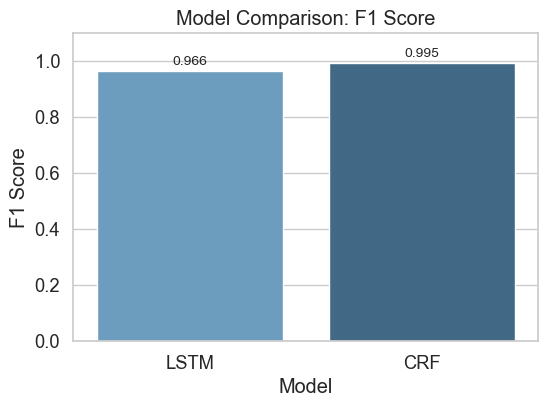

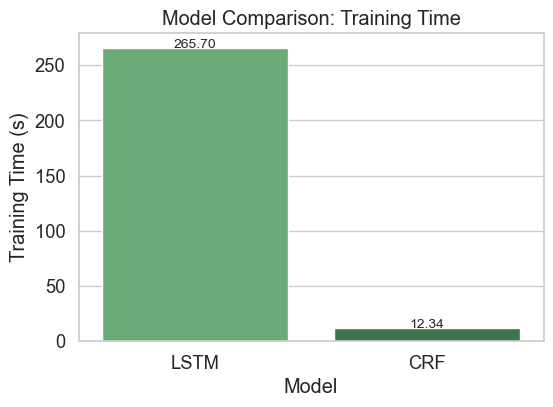

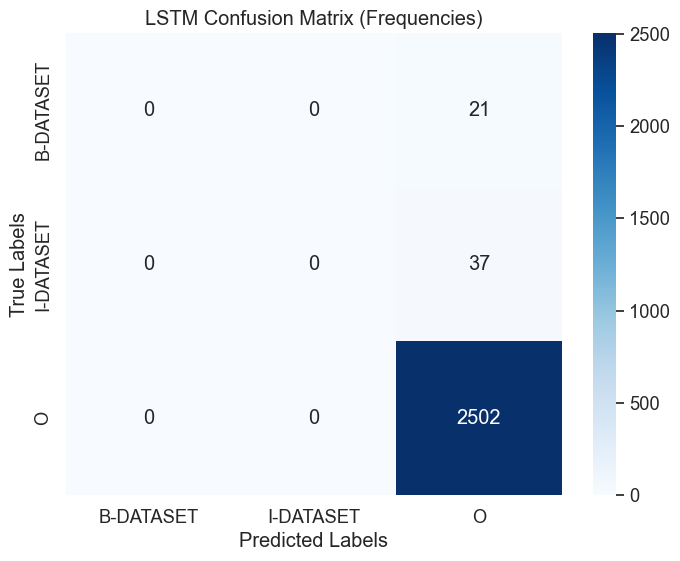

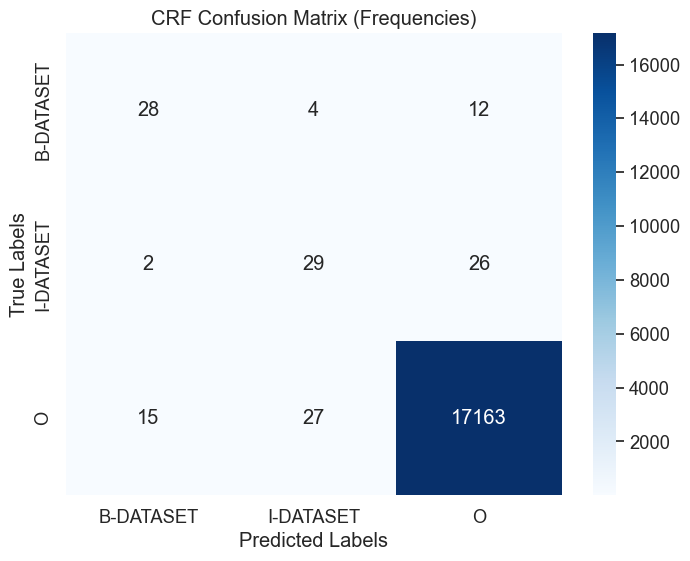

In [19]:
def plot_confusion_matrix(y_true, y_pred, labels, model_name):
    """
    Plot confusion matrix as heatmap showing frequency of true vs predicted values.
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title(f"{model_name} Confusion Matrix (Frequencies)")
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    plt.show()

def normalize_labels(labels):
    """
    Normalize labels to only: B-DATASET, I-DATASET, O
    """
    mapping = {
        "B": "B-DATASET",
        "I": "I-DATASET",
        "B-dataset": "B-DATASET",
        "I-dataset": "I-DATASET",
        "O": "O"
    }
    return [mapping.get(lbl, lbl) for lbl in labels]

def main():
    # ==================== Test ====================
    preds, trues = LSTMCitationNERFeatures.evaluate(lstm, test_loader, idx2tag, device)
    
    valid_preds, valid_trues = [], []
    for pred_seq, true_seq in zip(preds, trues):
        valid_length = min(len(pred_seq), len(true_seq))
        valid_preds.extend(pred_seq[:valid_length])
        valid_trues.extend(true_seq[:valid_length])
    
    # Normalize labels
    valid_preds = normalize_labels(valid_preds)
    valid_trues = normalize_labels(valid_trues)
    
    lstm_f1 = f1_score(valid_trues, valid_preds, average="weighted")

    y_pred = crf.predict(X_test)
    flat_trues = [label for seq in y_test for label in seq]
    flat_preds = [pred for seq in y_pred for pred in seq]
    crf_f1 = f1_score(flat_trues, flat_preds, average="weighted")

    results = pd.DataFrame({
        "Model": ["LSTM", "CRF"],
        "F1 Score": [lstm_f1, crf_f1],
        "Training Time (s)": [lstm_time, crf_time]
    })
    print("\n=== Comparison ===")
    print(results)
    
    results = pd.DataFrame({
        "Model": ["LSTM", "CRF"],
        "F1 Score": [lstm_f1, crf_f1],
        "Training Time (s)": [lstm_time, crf_time]
    })

    # ==================== Visualization ====================
    sns.set(style="whitegrid", font_scale=1.2)

    # Comparison plots
    plt.figure(figsize=(6,4))
    sns.barplot(x="Model", y="F1 Score", hue="Model", data=results,
            palette="Blues_d", legend=False)
    plt.title("Model Comparison: F1 Score")
    plt.ylim(0, 1.1)
    for i, v in enumerate(results["F1 Score"]):
        plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=10)
    plt.show()

    plt.figure(figsize=(6,4))
    sns.barplot(x="Model", y="Training Time (s)", hue="Model", data=results,
            palette="Greens_d", legend=False)
    plt.title("Model Comparison: Training Time")
    for i, v in enumerate(results["Training Time (s)"]):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)
    plt.show()

    # ==================== Confusion Matrices ====================
    
    label_list = ['B-DATASET', 'I-DATASET', 'O']
    plot_confusion_matrix(valid_trues, valid_preds, label_list, "LSTM")
    plot_confusion_matrix(flat_trues, flat_preds, label_list, "CRF")


if __name__ == "__main__":
    main()
